In [1]:
res = 48 	     			#pts per induction length lind - Input

import numpy as np
import time,sys
import datetime, string 
import cmath
import math
import os
import warnings
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import LogLocator
from IPython.core.pylabtools import figsize
from scipy import signal, misc,mean
from math import factorial
from operator import itemgetter, attrgetter
import matplotlib.lines as mlines
import glob
#from scipy.stats import nanmean
from matplotlib import colorbar
import scipy.interpolate
#from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy import ndimage
#from matplotlib.ticker import FormatStrFormatter
import numpy.ma as ma
import operator
from scipy import interpolate
from itertools import repeat

#rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
#rc('text', usetex=True)
lsize = 12
from tkinter import Tk
from tkinter.filedialog import askopenfilename

In [2]:
AR = 0 # Aspect ratio of the domain

In [3]:
num_rows_to_read = 802 # 819 corresponds to x = 0.040417764 m
dataZND = np.loadtxt("zndkin_Ys_cropped.dat", dtype='float',skiprows=1, max_rows=num_rows_to_read)
header = np.loadtxt("zndkin_Ys_cropped.dat", dtype='str',skiprows=0)
header = header[0,:]

## Defining variables from ZND data file
dataZND[-1,0] = round(dataZND[-1,0],5)
x = dataZND[:,0] 	#length in m
M = dataZND[:,1] 	#Mach number
U = dataZND[:,2] 	#axial velocity in m/s
p = dataZND[:,3] 	#pressure in Pa
T = dataZND[:,4] 	#Temperature in K
rho = dataZND[:,5] 	#density in kg/m3

print("Number of rows in x vector {}".format(np.size(x)))
print("End of the x_znd: {} cm".format(dataZND[-1,0]*100))

Number of rows in x vector 801
End of the x_znd: 4.1000000000000005 cm


['X(m)' 'Mach' 'V(m/s)' 'P(Pa)' 'T(K)' 'Rho(kg/m3)' 'H' 'H2' 'O' 'O2' 'OH'
 'HO2' 'H2O2' 'AR' 'H2O' 'Therm(1/s)']


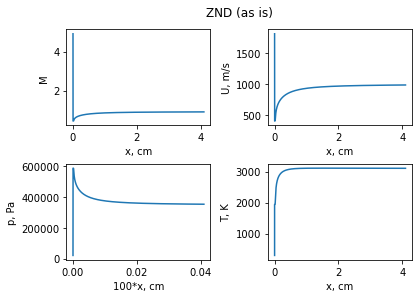

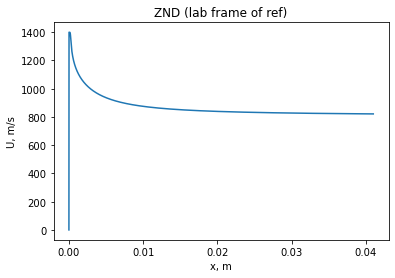

In [4]:
print(header)

## ZND plots
plt.subplot(221)
plt.plot(x*100,M)
plt.xlabel('x, cm')
plt.ylabel('M')

plt.subplot(222)
plt.plot(x*100,U)
plt.xlabel('x, cm')
plt.ylabel('U, m/s')

plt.subplot(223)
plt.plot(x,p)
plt.xlabel('100*x, cm')
plt.ylabel('p, Pa')

plt.subplot(224)
plt.plot(x*100,T)
plt.xlabel('x, cm')
plt.ylabel('T, K')

plt.suptitle("ZND (as is)")
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

## ZND plot (lab frame of reference)
plt.plot(x,-U + U[0])
plt.xlabel('x, m')
plt.ylabel('U, m/s')

plt.title("ZND (lab frame of ref)")
plt.show()

In [5]:
## ZND domain length and induction length from ZND calc ##
lx = x[-1] 	     			#ZND domain length from data file in [m] - Input
## SWJ
lind = 2.374141354125451e-04       			#ZND induction length from data file in [m] - Input  ## VICKY
##

dx = lind/res	     			#spatial resolution 	
x_znd = int(lx/dx)   			#number of points in ZND profile

##------------------------------------------
#nypts = 1 # number of rows in y for 2D cases
Ly = 20e-3 # 28e-3 # in metres
nypts = 1#math.ceil(1+int(Ly/dx)/2)*2 # number of rows in y for 2D cases
print(nypts)
##------------------------------------------

x_inflow_factor = 1.24
x_inflow = int(x_inflow_factor*x_znd + 1) 			#number of points ahead of det wave - Input ## VICKY
#x_inflow = int(1.5*x_znd + 1)

x_outflow_factor = 0.24
x_outflow = int(x_outflow_factor*x_znd + 1)
#x_outflow = int(0.5*x_znd + 1)			#number of points behind to avoid BC interacting with det. wave  ## VICKY

nxpts = x_inflow + x_znd + x_outflow	#number of points full domain	 
length = dx*nxpts			#physical length of full domain [m]
x_new = np.linspace(0,lx,num=x_znd+1)   #interpolation array with uniform resolution
domLengthBM = 100*(x_outflow_factor*lx + x_inflow_factor*lx + lx)			#domain length for blockMesh - to be modified based on Inputs   ## VICKY

1


In [6]:
print("ZND Domain length: {} m".format(lx))
print("dx = {} m".format(dx))
print("Number of points in x_znd: {}, x_inflow: {}, x_outflow: {}".format(x_znd, x_inflow, x_outflow))
print("Number of points in x-direction: {}".format(nxpts))
print("Length in x-direction: {} cm".format(length*100))
print("domain length for blockMesh: {} cm".format(domLengthBM))
print(np.size(x_new))

ZND Domain length: 0.041 m
dx = 4.94612782109469e-06 m
Number of points in x_znd: 8289, x_inflow: 10279, x_outflow: 1990
Number of points in x-direction: 20558
Length in x-direction: 10.168249574606463 cm
domain length for blockMesh: 10.168000000000001 cm
8290


In [7]:
print(x_znd, lx/dx, lx, nxpts, length, length+dx, domLengthBM)

8289 8289.312666999733 0.041 20558 0.10168249574606464 0.10168744187388573 10.168000000000001


(20559,) (20559,)


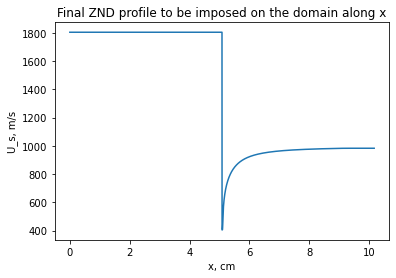

In [8]:
## Defining interpolation function
fU = interpolate.interp1d(x[1:],U[1:])
fp = interpolate.interp1d(x[1:],p[1:])
fT = interpolate.interp1d(x[1:],T[1:])

## New ZND interpolated array
U_new = fU(x_new)-U[0] #changing to lab. frame of reference
p_new = fp(x_new)
T_new = fT(x_new)

## Setting values ahead of det. wave (inflow) : zero velocity!
U_inflow = np.ones(x_inflow)*U[0]*0
p_inflow = np.ones(x_inflow)*p[0]
T_inflow = np.ones(x_inflow)*T[0]

## Setting values behind of det. wave (outflow) : merely extending the profile from tail of ZND
U_outflow = np.ones(x_outflow)*U_new[-1]
p_outflow = np.ones(x_outflow)*p[-1]
T_outflow = np.ones(x_outflow)*T[-1]

# Full array inflow + znd wave
#  r_ does row-wise merging
U_new = np.r_[U_inflow,U_new,U_outflow] + U[0]; # converting to shock frame of reference
p_new = np.r_[p_inflow,p_new,p_outflow]
T_new = np.r_[T_inflow,T_new,T_outflow]

#U_new = np.r_[U_inflow,U_new] + U[0]; # converting to shock frame of reference
#p_new = np.r_[p_inflow,p_new]
#T_new = np.r_[T_inflow,T_new]

## shock frame of reference plots
aa=np.linspace(0,domLengthBM,num=nxpts+1)
print(aa.shape,U_new.shape)
plt.plot(aa,U_new)
plt.xlabel('x, cm')
plt.ylabel('U_s, m/s')

plt.title("Final ZND profile to be imposed on the domain along x")
plt.show()

In [9]:
## Writing to file
znd_U = np.savetxt('znd_U.txt',np.transpose(np.tile(U_new,nypts)),delimiter=' ',fmt="%s",header='U (m/s)')
znd_p = np.savetxt('znd_p.txt',np.transpose(np.tile(p_new,nypts)),delimiter=' ',header='p (Pa)')
znd_T = np.savetxt('znd_T.txt',np.transpose(np.tile(T_new,nypts)),delimiter=' ',header='T (K)')

In [10]:
znd_UU = np.savetxt('znd_UU.txt',np.transpose(np.tile(U_new,1)),delimiter=' ',fmt="%s",header='U (m/s)')

In [11]:
with open('zndInputSim-report.txt', 'w') as g:
    g.write('p max, p min = {}, {} \n' .format(np.max(p_new), np.min(p_new)))
    g.write('T max, T min = {}, {} \n' .format(np.max(T_new), np.min(T_new)))
    g.write('Dcj, U_znd, U max, U min = {}, {}, {}, {} \n' .format(U[0], U[1], np.max(U_new), np.min(U_new)))

In [12]:
## Species loop
#Array with species names  
speciesNames = header[6:-1]
print(speciesNames)

['H' 'H2' 'O' 'O2' 'OH' 'HO2' 'H2O2' 'AR' 'H2O']


In [13]:
## Species loop
#Array with species names  
speciesNames = header[6:-1]
print(speciesNames)

#Column numbers corresponding to species data
dataColsSpecs = np.arange(6,len(header)-1, 1)
#print dataColsSpecs, len(header)
print(dataColsSpecs)

['H' 'H2' 'O' 'O2' 'OH' 'HO2' 'H2O2' 'AR' 'H2O']
[ 6  7  8  9 10 11 12 13 14]


In [14]:
with open('zndInputSim-report.txt', 'a+') as g:
    for k in range(len(speciesNames)):

        Y = dataZND[:,dataColsSpecs[k]] #mass fraction of Y_i

        f = interpolate.interp1d(x[1:],Y[1:])   #creating 1D interpolation function 

        Y_new = f(x_new) #evaluation of interpolation with new spatial array size 

        Y_inflow = np.ones(x_inflow)*Y[0] #setting inflow/conditions ahead of det. wave

        Y_outflow = np.ones(x_outflow)*Y[-1] #setting outflow/conditions behind of det. wave

        Y_new = np.r_[Y_inflow,Y_new,Y_outflow] #creating full array 
        #Y_new = np.r_[Y_inflow,Y_new]
        
        g.write('{}, {}, {} \n' .format(speciesNames[k], np.max(Y_new), np.min(Y_new)))

        #print >>g, speciesNames[k], max(Y_new), min(Y_new)

        np.savetxt('znd_'+speciesNames[k]+'.txt',np.transpose(np.tile(Y_new,nypts)),delimiter=' ',header='Y'+speciesNames[k]+'(-)')             #saving data to disk


In [15]:
# ========================================== #
## ===== WRITING OpenFOAM READY FILES ===== ##
# ========================================== #

# Creating folder to store OpenFOAM ready files
pathSAVE = '0/'
try: 
    os.makedirs(pathSAVE)
except OSError:
    if not os.path.isdir(pathSAVE):
        raise

#species = [ 'H', 'H2', 'O', 'OH', 'N2O', 'N2', 'H2O']

#array length
nxpts = len(Y_new)

with open('zndInputSim-report.txt', 'a+') as g:
    g.write('Domain length and number of points for blockMesh, nx and ny {}, {} and {}' .format(domLengthBM*100, nxpts, nypts))
    g.close()

print(len(p_new), len(T_new), len(U_new), len(Y_new))
#print species, len(species)

20559 20559 20559 20559


In [16]:
data = np.loadtxt("znd_"+speciesNames[0]+".txt", dtype='float',skiprows=1)
print(len(data))

20559


In [17]:
for j in range(len(speciesNames)):
    data = np.loadtxt("znd_"+speciesNames[j]+".txt", dtype='float',skiprows=1)

    #print len(data)

    #h = open(pathSAVE+speciesNames[j], 'a+')
    with open(pathSAVE+speciesNames[j], 'a+') as h:
        h.write('/*--------------------------------*- C++ -*----------------------------------*\ \n')
        h.write('| =========                 |                                                 | \n')
        h.write('| \\\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           | \n')
        h.write('|  \\\    /   O peration     | Version:  2.2.1                                 | \n')
        h.write('|   \\\  /    A nd           | Web:      www.OpenFOAM.org                      | \n')
        h.write('|    \\\/     M anipulation  |                                                 | \n')
        h.write('\*---------------------------------------------------------------------------*/ \n')
        h.write('FoamFile\n')
        h.write('{\n')
        h.write('    version     2.0;\n')
        h.write('    format      ascii;\n')
        h.write('    class       volScalarField;\n')
        h.write('    location    "0";\n')
        h.write('    object      '+speciesNames[j]+';\n')
        h.write('}\n')
        h.write('// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //\n')
        h.write('\n')
        h.write('dimensions      [0 0 0 0 0 0 0];\n')
        h.write('\n')
        h.write('internalField   nonuniform List<scalar>\n')
        h.write('{}' .format(nxpts*nypts))
        h.write('(\n')
        for k in range(len(data)):
            h.write('{} \n' .format(data[k]))
        h.write(')\n')
        h.write(';\n')
        h.write('\n')
        h.write('boundaryField\n')
        h.write('{\n')
        h.write('    leftWall\n')
        h.write('    {\n')
        h.write('        type            fixedValue;\n')
        h.write('        value           uniform '+str(dataZND[0,dataColsSpecs[j]])+';\n')
        h.write('    }\n')
        h.write('    rightWall\n')
        h.write('    {\n')
        h.write('        type            zeroGradient;\n')
        h.write('    }\n')
        h.write('    bottomWall\n')
        h.write('    {\n')
        h.write('        type            empty;\n')
        h.write('    }\n')
        h.write('    topWall\n')
        h.write('    {\n')
        h.write('        type            empty;\n')
        h.write('    }\n')
        h.write('    frontWall\n')
        h.write('    {\n')
        h.write('        type            empty;\n')
        h.write('    }\n')
        h.write('    backWall\n')
        h.write('    {\n')
        h.write('        type            empty;\n')
        h.write('    }\n')
        h.write('}\n')
        h.write('\n')
        h.write('\n')
        h.write('// ************************************************************************* //\n')
        h.close()

In [18]:
data = np.loadtxt("znd_p.txt", dtype='float',skiprows=1)

#print len(data)

with open(pathSAVE+'p', 'a+') as h:
    h.write('/*--------------------------------*- C++ -*----------------------------------*\ \n')
    h.write('| =========                 |                                                 | \n')
    h.write('| \\\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           | \n')
    h.write('|  \\\    /   O peration     | Version:  2.2.1                                 | \n')
    h.write('|   \\\  /    A nd           | Web:      www.OpenFOAM.org                      | \n')
    h.write('|    \\\/     M anipulation  |                                                 | \n')
    h.write('\*---------------------------------------------------------------------------*/ \n')
    h.write('FoamFile\n')
    h.write('{\n')
    h.write('    version     2.0;\n')
    h.write('    format      ascii;\n')
    h.write('    class       volScalarField;\n')
    h.write('    location    "0";\n')
    h.write('    object      p;\n')
    h.write('}\n')
    h.write('// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //\n')
    h.write('\n') 
    h.write('dimensions      [1 -1 -2 0 0 0 0];\n')
    h.write('\n') 
    h.write('internalField   nonuniform List<scalar>\n')
    h.write('{}' .format(nxpts*nypts))
    h.write('(\n')
    for k in range(len(data)):
        h.write('{} \n' .format(data[k]))
    h.write(')\n')
    h.write(';\n')
    h.write('\n')
    h.write('boundaryField\n')
    h.write('{\n')
    h.write('    leftWall\n')
    h.write('    {\n')
    h.write('        type            fixedValue;\n')
    h.write('        value           uniform '+str(dataZND[0,3])+';\n')
    h.write('    }\n')
    h.write('    rightWall\n')
    h.write('    {\n')
    h.write('        type            zeroGradient;\n')
    h.write('    }\n')
    h.write('    bottomWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('    topWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('    frontWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('    backWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('}\n')
    h.write('\n')
    h.write('\n')
    h.write('// ************************************************************************* //\n')
    h.close()



data = np.loadtxt("znd_T.txt", dtype='float',skiprows=1)

#print len(data)

with open(pathSAVE+'T', 'a+') as h:
    h.write('/*--------------------------------*- C++ -*----------------------------------*\ \n')
    h.write('| =========                 |                                                 | \n')
    h.write('| \\\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           | \n')
    h.write('|  \\\    /   O peration     | Version:  2.2.1                                 | \n')
    h.write('|   \\\  /    A nd           | Web:      www.OpenFOAM.org                      | \n')
    h.write('|    \\\/     M anipulation  |                                                 | \n')
    h.write('\*---------------------------------------------------------------------------*/ \n')
    h.write('FoamFile\n')
    h.write('{\n')
    h.write('    version     2.0;\n')
    h.write('    format      ascii;\n')
    h.write('    class       volScalarField;\n')
    h.write('    location    "0";\n')
    h.write('    object      T;\n')
    h.write('}\n')
    h.write('// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //\n')
    h.write('\n') 
    h.write('dimensions      [0 0 0 1 0 0 0];\n')
    h.write('\n') 
    h.write('internalField   nonuniform List<scalar>\n')
    h.write('{}' .format(nxpts*nypts))
    h.write('(\n')
    for k in range(len(data)):
        h.write('{} \n' .format(data[k]))
    h.write(')\n')
    h.write(';\n')
    h.write('\n')
    h.write('boundaryField\n')
    h.write('{\n')
    h.write('    leftWall\n')
    h.write('    {\n')
    h.write('        type            fixedValue;\n')
    h.write('        value           uniform ' + str(dataZND[0,4])+';\n')
    h.write('    }\n')
    h.write('    rightWall\n')
    h.write('    {\n')
    h.write('        type            zeroGradient;\n')
    h.write('    }\n')
    h.write('    bottomWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('    topWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('    frontWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('    backWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('}\n')
    h.write('\n')
    h.write('\n')
    h.write('// ************************************************************************* //\n')
    h.close()


data = np.loadtxt("znd_U.txt", dtype='float',skiprows=1)

#print len(data)

with open(pathSAVE+'U', 'a+') as h:
    h.write('/*--------------------------------*- C++ -*----------------------------------*\ \n')
    h.write('| =========                 |                                                 | \n')
    h.write('| \\\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           | \n')
    h.write('|  \\\    /   O peration     | Version:  2.2.1                                 | \n')
    h.write('|   \\\  /    A nd           | Web:      www.OpenFOAM.org                      | \n')
    h.write('|    \\\/     M anipulation  |                                                 | \n')
    h.write('\*---------------------------------------------------------------------------*/ \n')
    h.write('FoamFile\n')
    h.write('{\n')
    h.write('    version     2.0;\n')
    h.write('    format      ascii;\n')
    h.write('    class       volVectorField;\n')
    h.write('    location    "0";\n')
    h.write('    object      U;\n')
    h.write('}\n')
    h.write('// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //\n')
    h.write('\n') 
    h.write('dimensions      [0 1 -1 0 0 0 0];\n')
    h.write('\n') 
    h.write('internalField   nonuniform List<vector>\n')
    h.write('{}' .format(nxpts*nypts))
    h.write('(\n')
    for k in range(len(data)):
        h.write('({} 0 0)\n' .format(data[k]))
    h.write(')\n')
    h.write(';\n')
    h.write('\n')
    h.write('boundaryField\n')
    h.write('{\n')
    h.write('    leftWall\n')
    h.write('    {\n')
    h.write('        type            fixedValue;\n')
    h.write('        value           uniform ('+str(dataZND[0,2])+' 0 0) ;\n')
    h.write('    }\n')
    h.write('    rightWall\n')
    h.write('    {\n')
    h.write('        type            zeroGradient;\n')
    h.write('    }\n')
    h.write('    bottomWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('    topWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('    frontWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('    backWall\n')
    h.write('    {\n')
    h.write('        type            empty;\n')
    h.write('    }\n')
    h.write('}\n')
    h.write('\n')
    h.write('\n')
    h.write('// ************************************************************************* //\n')
    h.close()

sys.exit()


SystemExit: 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
